### Base

In [ ]:
import numpy as np
import random as rd
import math
import matplotlib.pyplot as plt
import csv
import multiprocessing as mp
import copy

In [ ]:
def readFile(fileName):
  with open(fileName) as file:
    data = [[x for x in line.split()] for line in file]
  file.close
  #header
  #data = data[1:-1]
  return data

In [ ]:
def stdDev(list):
  mean = sum(list)/len(list)
  return math.sqrt(sum((x - mean)**2 for x in list) / len(list))

# **Trabalho Prático II - Ant Colony Optimization**

Pedro Figueiredo Cipriano

# 1 - Introdução

  Neste trabalho procura-se por uma solução para o problema do maior caminho simples entre dois vértices de um grafo. Nas instâncias testadas, olhamos para grafos direcionados cujas arestas tem pesos de 1 a 10 e procuramos o maior caminho entre o vértice 1 e o vértice de maior índice.
  
  Para se aproximar o valor desejado, faz-se uso de um ACO. Resumidamente, o algoritmo gera alguns caminhos a partir do vértice 1 cuja criação é orientada probabilisticamente por uma matriz de ferômonio que atribui valores a cada aresta e pelos pesos das arestas. Dessa forma, a cada nó alcançado, escolhe-se um vizinho dele de acordo com as probabilidades e retornamos o caminho quando alcançamos o vértice N.
  
  Após essa primeira geração de soluções, atualizamos a matriz de ferômonio de modo a favorecer as arestas contidas no maior caminho gerado. Assim, a próxima geração tenderá ao último "ótimo" encontrado e espera-se que melhores soluções sejam encontradas a partir desse direcionamento da busca. Naturalmente, foram implementados parâmetros para controlar a velocidade de convergência desse processo bem como o número de gerações e quantidade de soluções por geração. A definição e o efeito desses parâmetros estão detalhados na próxima seção.

# 2 - Decisões de Implementação e Código

Nesta seção está contido o código do programa junto com explicações sobre as decisões tomadas em cada porção do algoritmo.

Em suma, modela-se o grafo usando uma matriz de adjacência e define-se a matriz de ferômonio com base na ideia de minTao e maxTao. Desse modo, inicializamos-a com o valor maxTao para toda aresta válida do grafo e zero para as demais. A cada geração evapora-se parte do ferômonio em toda aresta e aumentamos o ferômonio apenas das arestas contidas na melhor solução da geração atual.

## 2.1 - Classe Ant

Declara-se inicialmente a classe "ant" que representa cada uma das soluções encontradas. Armazena-se os vértices que compõe cada solução em ordem de visitação bem como o valor total do caminho. Utiliza-se também de overload de operadores para facilitar o código e de uma função de impressão.

In [ ]:
class ant:
  def __init__(self, antPath, pathSize):
    self.antPath = antPath
    self.pathSize = pathSize
  def __gt__(self, other):
        if(self.pathSize>other.pathSize):
            return True
        else:
            return False
  def __lt__(self, other):
        if(self.pathSize<other.pathSize):
            return True
        else:
            return False
  def __eq__(self, other):
        if(self.pathSize == other.pathSize):
            return True
        else:
            return False
  def __add__(self, other):
          return float(self.pathSize + other.pathSize)

In [ ]:
def print_ant(ant):
  print(*ant.antPath)
  print(ant.pathSize)

## 2.2 - Definição matrizes de adjacência e ferômonio

As matrizes de adjacência e ferômonio são aqui definidas. Para ambas matrizes, as arestas que não estão presentes são identificadas com um 0. Para demais arestas, o feromônio é inicializado com maxTao e o peso é armazenado na matriz de adjacência.

In [ ]:
def defineMatrices(data, maxTao, dim):

  adjMatrix = [[0 for col in range(dim)] for row in range(dim)]
  taoMatrix = [[0 for col in range(dim)] for row in range(dim)]

  for line in data:
    adjMatrix[int(line[0])][int(line[1])] = line[2]
    taoMatrix[int(line[0])][int(line[1])] = maxTao

  return adjMatrix, taoMatrix

## 2.3 - Nova Geração

  O cálculo de uma nova geração é o núcleo do algoritmo. A função newGen apenas chama a função buildPath acrescentando a solução retornada até que a nova população gerada seja do tamanho esperado.
  
  buildPath por sua vez é responsável pela geração de um novo indivíduo. Para isso, recebemos as matrizes de adjacência e ferômonio bem como os parâmetros alfa e beta. Começa-se por definir a solução de tamanho 0 e vértice inicial 1. A partir disso, definimos o vértice atual como 1 e uma lista de probabilidades onde cada vértice não visitado do grafo recebe um peso dado por:
   
   taoMatrix[currentNode][i]^alfa*(adjMatrix[currentNode][i]/10)^beta
  
  A função choices então escolhe um desses vértices com base nos pesos definidos por essa lista. Note que se um vértice não é adjacente ao atual, seu peso é zero e, portanto jamais será escolhido. Adicionamos esse novo nó à solução e definimos-o como o vértice atual.
  
  Repete-se esse processo até que se alcance o vértice v ou chega-se a um vértice cujos vizinhos já foram todos visitados. Nesse último caso, retornamos o maior subcaminho dessa solução cujo último vértice é vizinho de v acrescido de v. Com esse ajuste nunca retornamos soluções inválidas porque se nenhum vértice da solução for vizinho de v, retornamos uma solução de tamanho 0 que não será adicionada na população.

In [ ]:
def buildPath(taoMatrix, adjMatrix, dim, alfa, beta):
  u = 1
  v = dim-1
  currentNode = u

  validPath = []
  validPathSize = 0

  path = [u]
  pathSize = 0

  if(adjMatrix[u][v] != 0):
    validPath = path

  validVertices = list(range(1,len(adjMatrix[currentNode])))
  validVertices.remove(currentNode)
  #if not validVertices or v not in validVertices:
  #  return path, pathSize
  validVerticesProb = [taoMatrix[currentNode][i]**alfa*(adjMatrix[currentNode][i]/10)**beta for i in list(validVertices)]

  for i in range(2, dim):
    nextNode = rd.choices(validVertices, weights=validVerticesProb, cum_weights=None, k=1)
    #if adjMatrix[currentNode][nextNode[0]]==0:
    #  print("ERROR")
    #  return path, pathSize

    path.append(nextNode[0])
    pathSize += adjMatrix[currentNode][nextNode[0]]
    currentNode = nextNode[0]

    if adjMatrix[currentNode][v] !=0:
      validPath = path
      validPathSize = pathSize

    if currentNode == v:
      return path, pathSize

    validVertices.remove(currentNode)
    #if not validVertices:
    #  print("ERROR")
    #  return path, pathSize

    validVerticesProb = [taoMatrix[currentNode][i]**alfa*adjMatrix[currentNode][i]**beta for i in list(validVertices)]
    if(sum(validVerticesProb) == 0):
      validPath.append(v)
      if(len(validPath)>1):
        validPathSize += adjMatrix[validPath[-2]][v]
      return validPath, validPathSize

  return path, pathSize

In [ ]:
def newGen(probMatrix, adjMatrix, numAnts, dim, alfa, beta):
  currentGen = []
  for j in range(numAnts):
    antPath, pathSize = buildPath(probMatrix, adjMatrix, dim, alfa, beta)
    if(pathSize!=0):
     currentGen.append(ant(antPath, pathSize))
  return currentGen

## 2.4 - Atualiza Probabilidades

Atualizamos a matriz de ferômonio multiplicando sua entradas por 1 - taxa_de_evaporação não permitindo que arestas validas fiquem menores que minTao. Além disso, aumentamos o ferômonio apenas das arestas contidas na melhor solução da geração. Para essas arestas, somamos 'eta' evitando que o novo valor passe de maxTao. Note que 'eta' foi definido aqui como (maxTao-minTao)*0.1(currentBest.pathSize/genMeanSize-1), ou seja, aumenta-se o ferômonio em 10% no intervalo de ferômonio válido vezes quão melhor a nova solução é em relação a média das soluções. Note que isso quer dizer que soluções que melhoram muito aumentam muito o ferômonio do caminho. Outros "etas" foram testados mas esse se provou especialmente interessante.

In [ ]:
def updateProb(currentBest, taoMatrix, evaporationRate, minTao, maxTao, genMeanSize):
  ##deltaProb = [[0 for col in range(len(probMatrix))] for row in range(len(probMatrix))]
  #for col in probMatrix:
  #  for j in col:
  #    if j!=0:
  #      j = max(j*(1-evaporationRate),minTao)
  eta = (maxTao-minTao)*0.1*(currentBest.pathSize/genMeanSize-1)
  taoMatrix = [[max(x*(1-evaporationRate),minTao) if x>0 else 0 for x in col] for col in taoMatrix]
  for i in range(len(currentBest.antPath)-1):
    taoMatrix[currentBest.antPath[i]][currentBest.antPath[i+1]] = min(taoMatrix[currentBest.antPath[i]][currentBest.antPath[i+1]]+eta, maxTao)

  return taoMatrix

## 2.5 - Algoritmo

Essa função executa o loop do algoritmo. Lemos o arquivo, definimos as matrizes de adjacência e ferômonio. Após isso, geramos 'iterations' novas gerações armazenando a melhor e a pior solução, bem como a média para cada iteração e atualizando a matriz de ferômonio. Por fim, retornamos a solução e os dados coletados.

In [ ]:
def runAlg (iterations=100, minTao=0.01, maxTao=1, evaporationRate=0.02, alfa=1, beta=4, numAnts=None, fileName=None):
  data = readFile(fileName)
  dim = max(map(max, data))+1
  adjMatrix, taoMatrix = defineMatrices(data, maxTao, dim)

  if(numAnts == None):
    numAnts = len(data)

  bestSolutions = []
  meanSize = []
  worstSolutions = []
  globalBestEvo = []
  globalBest = ant(0,0)
  diversity = []

  for i in range(iterations):

    if(i%10==9):
      taoMatrix = updateProb(globalBest, taoMatrix, evaporationRate, minTao, maxTao, meanSize[i-1])

    currentGen = newGen(taoMatrix, adjMatrix, numAnts, dim, alfa, beta)

    currentBest = max(currentGen)
    if(globalBest == ant(0,0) or currentBest>globalBest):
      globalBest = currentBest
    bestSolutions.append(currentBest)
    globalBestEvo.append(globalBest.pathSize)
    #filter(lambda ant: ant.pathSize > 0,
    worstSolutions.append(min(currentGen))
    meanSize.append(sum([solution.pathSize for solution in currentGen])/len(currentGen))
    #currentGen.sort()
    #diversity.append(stdDev([solution.pathSize for solution in currentGen[int(0.5*len(currentGen)):]]))

    taoMatrix = updateProb(currentBest, taoMatrix, evaporationRate, minTao, maxTao, meanSize[i])

  return bestSolutions, meanSize, worstSolutions, globalBest, globalBestEvo, diversity

## 2.6 - Execução

A função abaixo é a função chamada de fato para os experimentos. Passa-se os mesmos argumentos de runAlg acrescido da quantidade de execuções que se quer. No final, imprime-se o desvio padrão para as melhores soluções, a melhor solução encontrada para cada chamada do algoritmo e o gráfico da média dos dados coletados.

In [ ]:
def trainAndTest(numTests, iterations, minTao, maxTao, evaporationRate, alfa, beta, numAnts, fileName):
 bestPathUpperBound = []
 mean_bestPath = []
 bestPathLowerBound = []
 mean_globalBestEvo = []

 mean_diversity = []

 mean_meanPath = []

 mean_worstPath = []

 bestSolutions = []

 mean_bestPath, mean_meanPath, mean_worstPath, best, mean_globalBestEvo, mean_diversity = runAlg(iterations, minTao, maxTao, evaporationRate, alfa, beta, numAnts, fileName)
 bestSolutions.append(best)

 bestPathUpperBound = mean_bestPath
 bestPathLowerBound = mean_bestPath

 for i in range(numTests-1):
   bestPath, meanPath, worstPath, best, globalBestEvo, diversity = runAlg(iterations, minTao, maxTao, evaporationRate, alfa, beta, numAnts, fileName)

   if(i<1):
    bestPathUpperBound = [max(bestPath[i].pathSize, bestPathUpperBound[i].pathSize) for i in range(len(bestPath))]
    bestPathLowerBound = [min(bestPath[i].pathSize, bestPathLowerBound[i].pathSize) for i in range(len(bestPath))]
    mean_bestPath = [x + y for x, y in zip(mean_bestPath, bestPath)]
    mean_worstPath = [x + y for x, y in zip(mean_worstPath, worstPath)]
   else:
    bestPathUpperBound = [max(bestPath[i].pathSize, bestPathUpperBound[i]) for i in range(len(bestPath))]
    bestPathLowerBound = [min(bestPath[i].pathSize, bestPathLowerBound[i]) for i in range(len(bestPath))]
    mean_bestPath = [x + y.pathSize for x, y in zip(mean_bestPath, bestPath)]
    mean_worstPath = [x + y.pathSize for x, y in zip(mean_worstPath, worstPath)]

   #mean_diversity = [x + y for x, y in zip(mean_diversity, diversity)]
   mean_meanPath = [x + y for x, y in zip(mean_meanPath, meanPath)]
   mean_globalBestEvo = [x + y for x, y in zip(mean_globalBestEvo, globalBestEvo)]

   bestSolutions.append(best)

 if(numTests!=1):
  #mean_diversity = [x/numTests for x in mean_diversity]
  mean_bestPath = [x/numTests for x in mean_bestPath]
  mean_meanPath = [x/numTests for x in mean_meanPath]
  mean_worstPath = [x/numTests for x in mean_worstPath]
  mean_globalBestEvo = [x/numTests for x in mean_globalBestEvo]


 print("Média para melhores soluções: " + str(sum([ant.pathSize for ant in bestSolutions])/len(bestSolutions)))
 print("Desvio padrão para melhores soluções: " + str(stdDev([ant.pathSize for ant in bestSolutions])) + "\n")
 print("Melhor Solução encontrada para cada treino: ")
 for solution in bestSolutions:
   print_ant(solution)
 print("\nDados:\n")

 if(iterations!=1):
  plt.title("Mean Fitness Evolution")
  plt.rcParams['figure.figsize'] = [20, 10]
  plt.plot(mean_globalBestEvo, 'y')
  plt.plot(mean_bestPath, 'g')
  plt.plot(mean_worstPath, 'r')
  plt.plot(mean_meanPath, 'b')
  #plt.plot(mean_diversity)
  plt.fill_between(range(len(mean_bestPath)),bestPathUpperBound, bestPathLowerBound, color="green", alpha = 0.2)


 bestPath.clear()
 meanPath.clear()
 worstPath.clear()

 mean_bestPath.clear()
 mean_meanPath.clear()
 mean_worstPath.clear()


# 3 - Experimentos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving entrada2.txt to entrada2.txt
Saving entrada3.txt to entrada3.txt


## 3.1 - Teste entrada2

Média para melhores soluções: 116.5
Desvio padrão para melhores soluções: 10.5

Melhor Solução encontrada para cada treino: 
1 19 14 16 12 7 13 10 17 11 2 5 3 15 9 20
106
1 19 8 12 9 3 15 14 11 7 13 10 2 5 17 18 16 20
127

Dados:



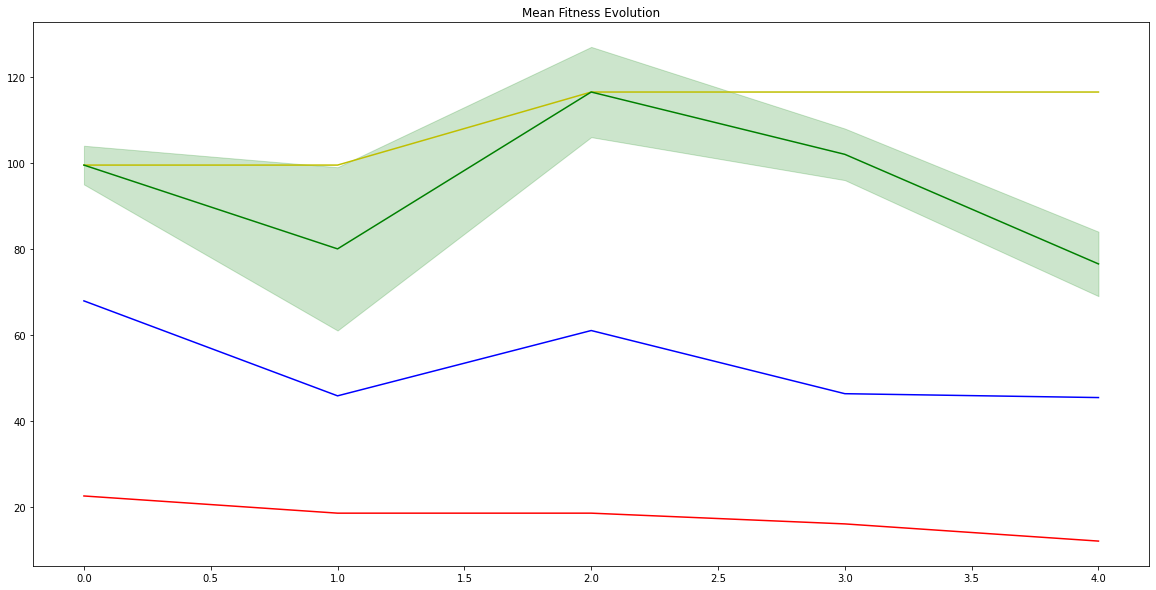

In [ ]:
rd.seed(42)
trainAndTest(2, 5, 1, 50, 0.2, 1, 1, 5, "entrada2.txt")

Média para melhores soluções: 166.6
Desvio padrão para melhores soluções:1.6041612554021285

Melhor Solução encontrada para cada treino:
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 16 6 5 3 4 10 11 18 13 7 9 8 12 17 2 20
166
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 18 16 6 5 3 4 7 13 10 11 2 20
167
1 19 16 6 5 15 12 17 2 10 18 11 4 7 13 9 8 3 14 20
163
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 18 16 6 5 3 4 7 13 10 11 2 20
167
1 19 15 14 16 6 5 3 4 10 11 18 13 7 9 8 12 17 2 20
166
1 17 2 12 9 8 3 4 7 13 10 11 18 19 16 6 5 15 14 20
162
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 16 6 5 15 2 12 17 18 13 10 11 4 7 9 8 3 14 20
164
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 18 16 6 5 3 4 7 13 10 11 2 20
167
1 19 15 14 9 8 12 17 18 16 6 5 3 4 7 1

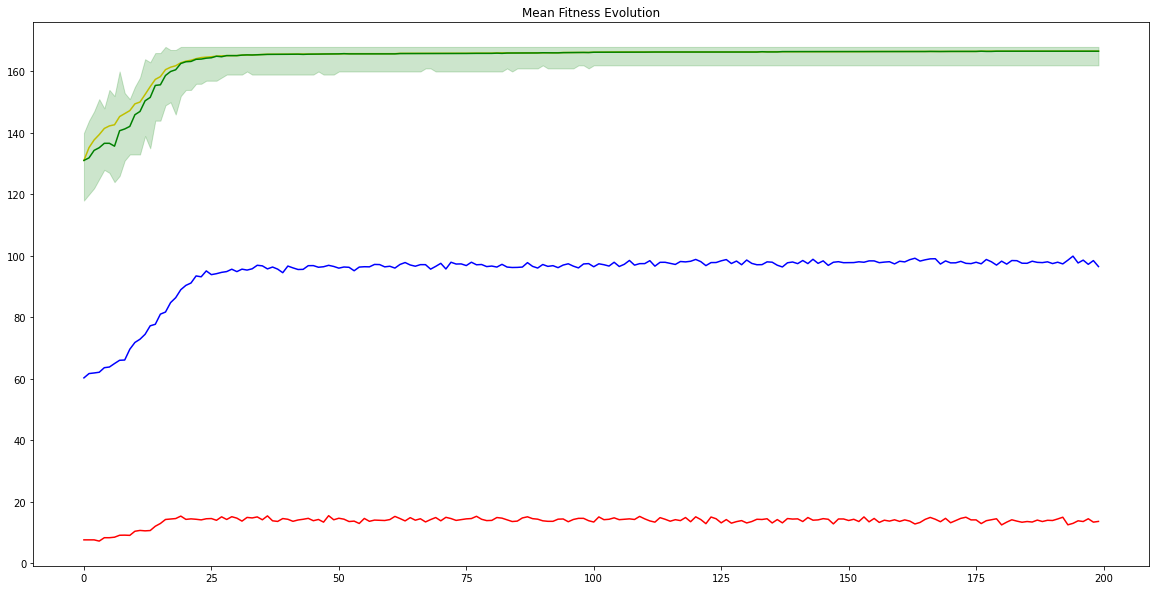

In [ ]:
rd.seed(42)
trainAndTest(30, 200, 1, 50, 0.2, 1, 1, None, "entrada2.txt")

## 3.2 - Testes iniciais em 1

In [ ]:
rd.seed(42)
trainAndTest(30, 400, 1, 50, 0.02, 1, 1, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 400, 0.01, 1, 0.02, 1, 1, 60, "entrada1.txt")

## 3.3 - Testes com beta

In [ ]:
rd.seed(42)
trainAndTest(30, 400, 0.01, 1, 0.02, 0.5, 1, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 2.2, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 0.8, 2.2, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 3, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(5, 500, 0.01, 1, 0.02, 1, 4, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 5, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(5, 500, 0.01, 1, 0.02, 1, 7, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(5, 500, 0.01, 1, 0.02, 1, 10, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 12, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(5, 500, 0.01, 1, 0.02, 1, 15, 60, "entrada1.txt")

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 5, 60, "entrada2.txt")

## 3.4 - Alfa

Média para melhores soluções: 988.1333333333333
Desvio padrão para melhores soluções: 1.431394036905592

Melhor Solução encontrada para cada treino: 
1 68 96 98 67 59 80 84 2 12 37 15 88 94 82 65 86 61 81 79 63 24 56 60 99 3 90 35 11 23 57 34 42 18 29 44 75 28 26 36 72 97 9 27 20 85 17 22 31 50 73 77 78 52 93 83 33 48 40 46 64 62 21 6 53 91 92 14 66 95 10 7 87 41 51 76 45 39 49 69 30 58 32 71 16 55 13 19 70 54 47 74 25 5 4 43 8 38 89 100
987
1 68 55 87 58 32 48 77 11 54 35 85 78 28 42 98 88 94 13 37 2 86 92 26 60 8 39 89 9 27 57 80 79 18 29 44 56 93 14 66 95 36 24 20 40 7 47 90 34 5 19 30 97 50 72 71 43 25 61 96 3 76 45 15 67 59 4 41 84 52 99 6 49 17 46 75 23 83 33 73 38 81 64 62 16 21 65 82 63 70 51 74 53 12 10 22 31 91 69 100
988
1 68 12 99 6 63 19 70 51 76 52 38 26 88 74 53 91 65 4 41 40 46 57 28 55 87 84 2 64 62 16 9 27 37 43 25 5 66 50 92 94 82 79 18 56 60 8 39 67 35 11 80 30 58 71 81 97 86 61 69 13 83 49 17 54 21 96 72 59 22 31 89 15 7 47 33 73 78 93 29 44 95 20 85 77 75 23 42 98

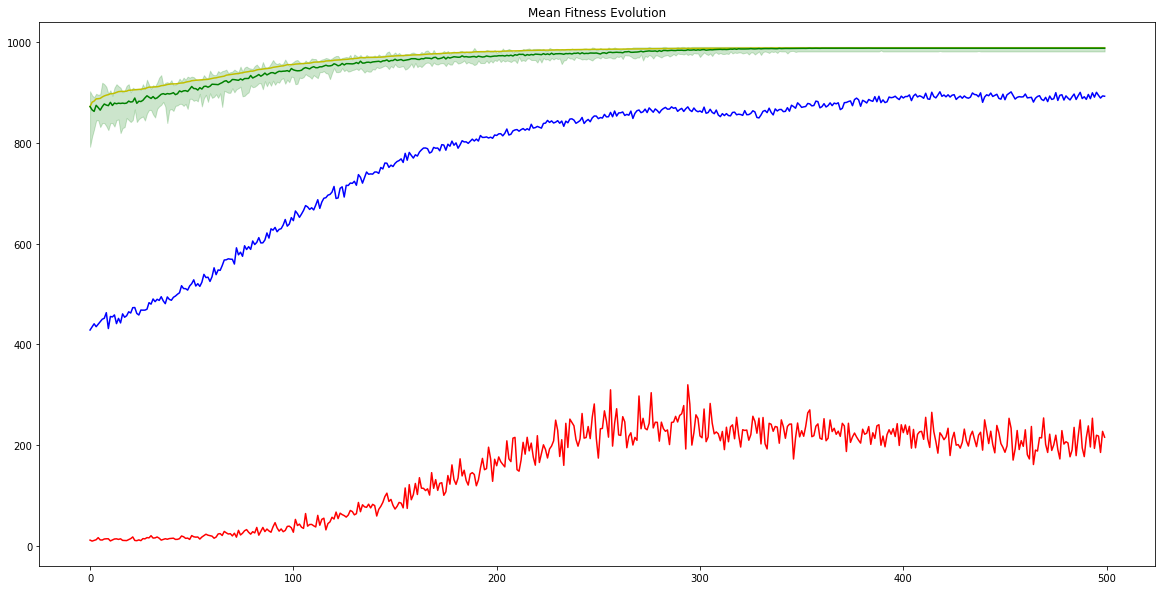

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 2, 5, 60, "entrada1.txt")

Média para melhores soluções: 988.2666666666667
Desvio padrão para melhores soluções: 1.2631530214330944

Melhor Solução encontrada para cada treino: 
1 37 58 32 2 64 62 56 4 41 27 75 13 45 39 5 28 55 80 79 34 7 47 54 60 88 81 70 17 76 84 52 93 83 49 69 30 99 73 8 48 97 94 63 86 40 43 25 42 10 77 87 91 90 68 96 98 67 24 20 85 78 38 89 3 61 65 82 44 51 36 95 92 26 35 74 53 12 57 50 21 14 66 33 46 19 11 31 23 71 16 9 18 29 6 72 59 22 15 100
989
1 37 2 64 28 21 91 49 17 22 57 95 10 31 69 13 90 34 84 85 78 93 5 19 30 52 74 6 48 36 62 43 68 55 41 44 51 53 14 98 3 94 63 24 38 23 42 18 56 92 29 76 45 9 4 46 40 7 47 59 80 32 73 33 86 88 70 82 39 71 27 12 99 20 66 50 96 72 58 77 87 81 97 16 79 54 60 25 61 65 26 83 8 89 15 67 35 11 75 100
988
1 38 5 70 81 97 16 9 58 42 18 68 12 45 33 17 82 13 88 20 85 14 51 74 53 91 90 75 28 55 7 47 60 44 39 71 56 87 41 84 40 46 76 72 77 24 26 95 10 23 79 66 62 43 36 54 89 21 80 30 99 57 78 52 93 34 19 49 65 92 35 11 83 29 50 73 8 6 48 25 96 98 3 94 59 22 31 69 

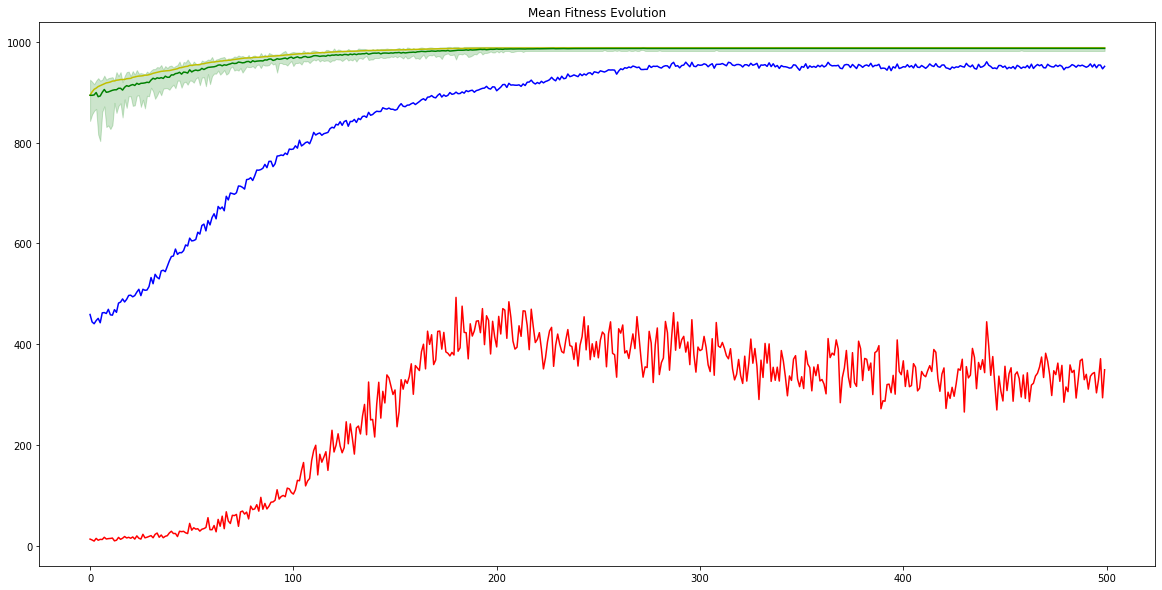

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 3, 7, 60, "entrada1.txt")

Média para melhores soluções: 920.2
Desvio padrão para melhores soluções:9.927738916792686

Melhor Solução encontrada para cada treino:
1 93 4 13 78 14 98 90 68 96 32 34 73 8 48 5 76 29 6 45 31 50 12 18 86 83 87 57 21 23 97 94 80 84 85 72 56 15 79 74 75 91 35 36 47 30 7 63 41 51 25 42 66 60 99 65 43 11 40 17 54 3 82 59 27 20 77 64 89 9 19 49 2 71 16 55 26 88 28 52 39 33 46 22 58 37 95 67 38 70 53 10 81 62 61 24 44 92 69 100
915
1 50 92 78 8 6 4 68 12 37 57 30 7 47 59 27 64 28 31 23 71 24 52 43 16 55 34 84 73 9 18 91 17 58 87 96 76 72 61 81 60 98 89 15 85 3 82 70 69 13 19 21 94 80 77 99 88 11 35 67 22 53 2 95 36 83 49 14 86 40 26 90 56 65 41 51 25 32 29 93 38 46 79 63 45 39 54 74 33 42 10 5 20 66 62 48 97 44 75 100
914
1 85 17 80 32 14 73 8 6 76 84 52 98 45 96 75 26 40 48 18 92 69 93 88 7 38 23 57 24 36 99 3 25 5 70 13 56 89 39 33 46 41 29 20 66 51 74 95 72 30 63 82 49 2 64 62 43 4 50 59 34 19 11 31 91 67 61 16 79 54 22 15 35 77 78 9 27 12 37 81 87 58 68 55 21 86 71 65 53 42 83 60 44 97

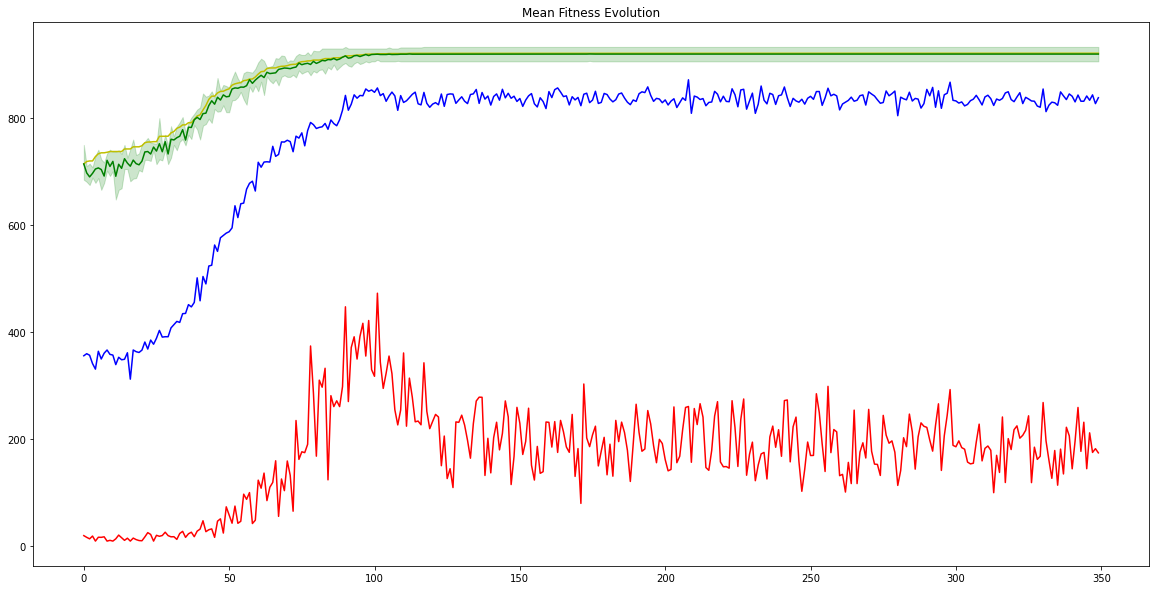

In [ ]:
rd.seed(42)
trainAndTest(5, 350, 0.01, 1, 0.05, 3, 1, 60, "entrada1.txt")

Média para melhores soluções: 974.4
Desvio padrão para melhores soluções:2.4979991993593593

Melhor Solução encontrada para cada treino:
1 21 84 17 82 67 35 85 14 65 4 68 96 36 99 73 83 33 45 80 16 9 48 52 88 70 54 47 86 2 34 42 18 92 26 58 32 31 91 90 29 50 11 75 13 37 19 30 79 66 62 63 59 77 95 20 98 72 61 53 12 87 93 97 44 39 24 74 43 8 81 60 25 51 76 89 3 10 7 23 5 46 6 49 56 22 15 40 71 27 57 94 28 55 41 64 78 38 69 100
971
1 27 76 52 88 78 26 40 71 16 64 6 45 61 53 15 13 36 72 98 67 24 56 22 57 2 95 20 29 55 10 17 82 59 4 90 35 85 14 66 62 43 94 28 38 81 34 7 23 42 19 11 75 21 96 3 25 46 31 12 18 91 30 99 54 47 33 5 32 73 77 93 87 41 84 37 58 48 97 44 68 80 79 63 70 51 74 89 50 86 83 60 8 39 49 65 92 9 69 100
977
1 68 80 84 96 76 89 74 25 51 36 24 26 40 46 57 28 98 18 60 8 38 99 20 35 85 78 52 93 87 73 64 62 19 44 30 6 45 7 5 70 17 22 49 56 92 71 32 31 12 94 59 4 27 67 63 58 42 66 95 10 77 97 9 3 82 65 23 72 61 69 13 37 2 86 88 53 29 47 90 16 55 41 91 15 11 83 43 50 21 14 48 34 8

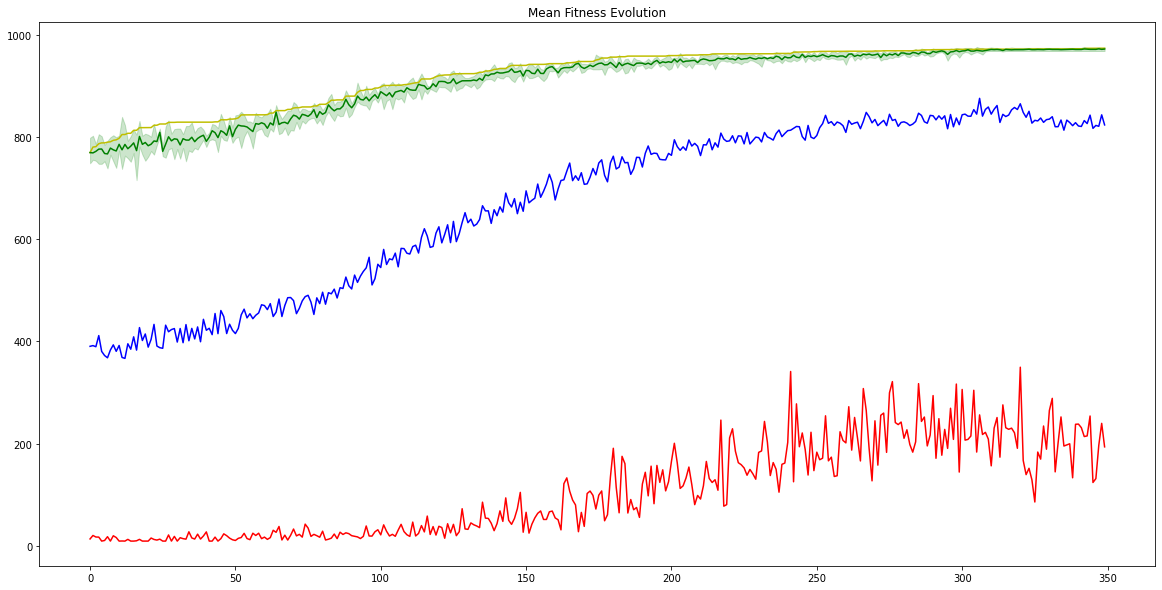

In [ ]:
rd.seed(42)
trainAndTest(5, 350, 0.01, 1, 0.02, 2, 2, 60, "entrada1.txt")

Média para melhores soluções: 985.6
Desvio padrão para melhores soluções:1.3564659966250536

Melhor Solução encontrada para cada treino:
1 85 58 42 19 49 17 82 39 71 32 73 74 25 51 53 31 50 21 18 68 26 83 33 48 34 5 66 95 92 29 44 90 35 36 24 15 67 59 80 4 41 64 55 87 91 65 72 61 96 11 62 77 99 20 98 3 60 8 81 70 97 16 2 12 10 69 30 63 86 40 7 47 54 22 57 78 52 38 94 13 88 28 89 9 27 75 93 14 84 37 43 56 6 45 23 79 46 76 100
985
1 27 75 28 24 38 26 36 68 12 45 33 86 37 2 47 90 7 87 84 17 39 54 35 78 93 14 65 82 79 34 42 98 72 58 77 99 20 85 3 61 96 11 10 5 95 92 29 50 53 91 15 18 23 71 81 97 16 9 55 13 80 32 73 66 62 40 46 57 30 52 88 94 63 19 70 83 43 8 6 48 49 56 60 44 51 76 4 41 64 67 59 22 31 89 21 74 25 69 100
988
1 45 61 8 81 97 16 21 86 52 99 73 62 77 75 91 35 74 3 90 26 88 5 76 89 15 25 46 19 63 70 54 60 44 43 50 82 13 36 24 57 30 58 37 2 95 92 9 27 20 66 33 48 34 7 47 78 28 38 23 42 40 6 72 98 67 59 80 79 68 96 11 83 29 55 87 84 85 17 39 71 32 31 69 18 56 93 14 51 53 12 94 10 

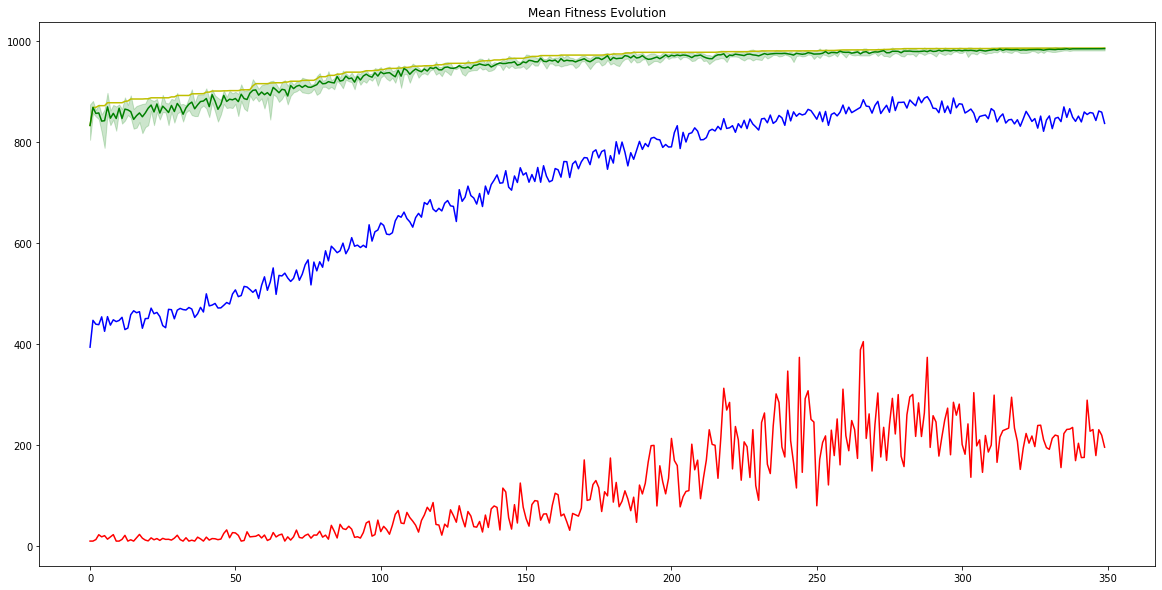

In [ ]:
rd.seed(42)
trainAndTest(5, 350, 0.01, 1, 0.02, 2, 4, 60, "entrada1.txt")

Média para melhores soluções: 988.0
Desvio padrão para melhores soluções:0.6324555320336759

Melhor Solução encontrada para cada treino:
1 85 3 82 59 4 46 6 23 36 47 78 44 90 35 11 80 30 99 20 40 43 8 48 34 55 41 84 52 74 57 5 19 63 14 51 76 45 39 49 56 93 83 71 16 2 95 92 26 58 42 18 29 50 73 66 62 61 53 91 65 86 37 21 33 17 54 22 15 25 7 87 79 68 96 98 67 60 88 70 97 94 13 72 77 75 28 24 38 12 69 10 32 31 89 9 27 81 64 100
989
1 50 92 35 85 14 41 40 71 16 22 58 32 2 12 99 73 33 86 37 21 23 57 78 44 95 20 98 79 34 42 66 62 83 49 65 82 59 80 84 17 24 52 38 94 10 77 75 15 18 56 93 68 26 88 53 91 67 45 9 4 43 29 89 39 5 70 51 74 27 64 28 55 87 81 60 25 46 6 72 61 96 3 76 63 19 30 7 11 31 69 13 90 36 8 48 97 54 47 100
988
1 50 96 98 13 83 60 44 75 28 31 12 94 20 48 34 42 19 49 33 17 82 39 71 32 14 66 95 36 68 80 16 21 65 86 61 8 81 64 5 70 51 25 53 2 89 3 90 10 23 79 77 99 73 62 40 46 57 84 85 78 52 38 26 88 74 43 29 55 7 47 54 35 11 91 67 63 59 22 58 37 15 69 30 6 45 24 56 87 93 4 41 27 

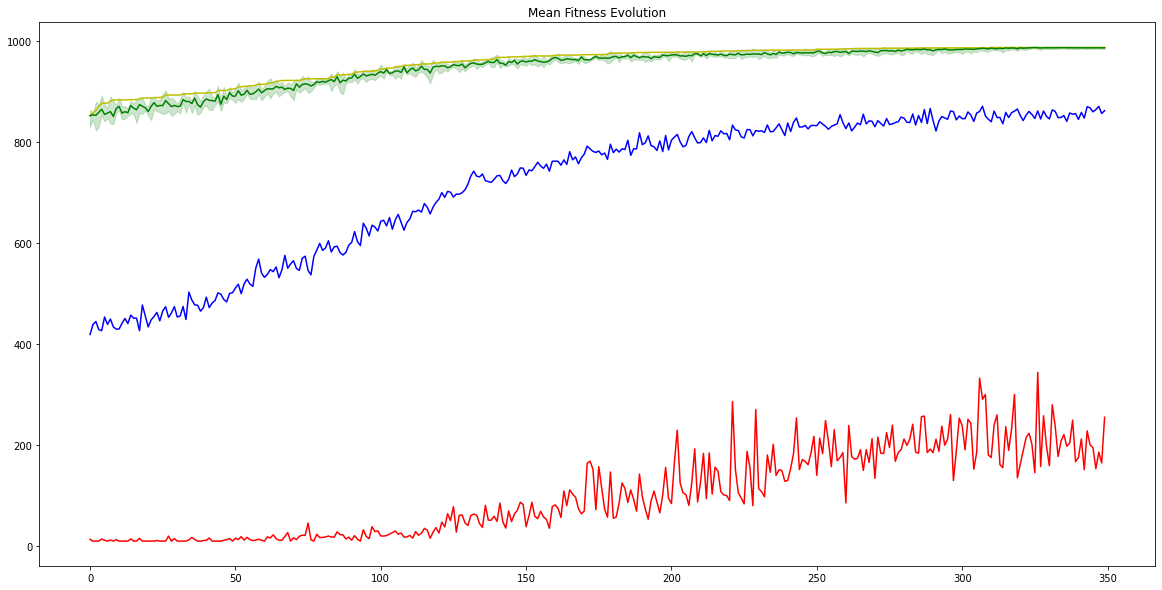

In [ ]:
rd.seed(42)
trainAndTest(5, 350, 0.01, 1, 0.02, 2, 4, 90, "entrada1.txt")

Média para melhores soluções: 987.4
Desvio padrão para melhores soluções:1.2000000000000002

Melhor Solução encontrada para cada treino:
1 85 3 82 59 4 46 6 23 36 47 78 44 90 35 11 80 30 99 20 40 43 8 48 34 55 41 84 52 74 57 5 19 63 14 51 76 45 39 49 56 93 83 71 16 2 95 92 26 58 42 18 29 50 73 66 62 61 53 91 65 86 37 21 33 17 54 22 15 25 7 87 79 68 96 98 67 60 88 70 97 94 13 72 77 75 28 24 38 12 69 10 32 31 89 9 27 81 64 100
989
1 50 92 35 85 14 41 40 71 16 22 58 32 2 12 99 73 33 86 37 21 23 57 78 44 95 20 98 79 34 42 66 62 83 49 65 82 59 80 84 17 24 52 38 94 10 77 75 15 18 56 93 68 26 88 53 91 67 45 9 4 43 29 89 39 5 70 51 74 27 64 28 55 87 81 60 25 46 6 72 61 96 3 76 63 19 30 7 11 31 69 13 90 36 8 48 97 54 47 100
988
1 50 96 98 13 83 60 44 75 28 31 12 94 20 48 34 42 19 49 33 17 82 39 71 32 14 66 95 36 68 80 16 21 65 86 61 8 81 64 5 70 51 25 53 2 89 3 90 10 23 79 77 99 73 62 40 46 57 84 85 78 52 38 26 88 74 43 29 55 7 47 54 35 11 91 67 63 59 22 58 37 15 69 30 6 45 24 56 87 93 4 41 27 

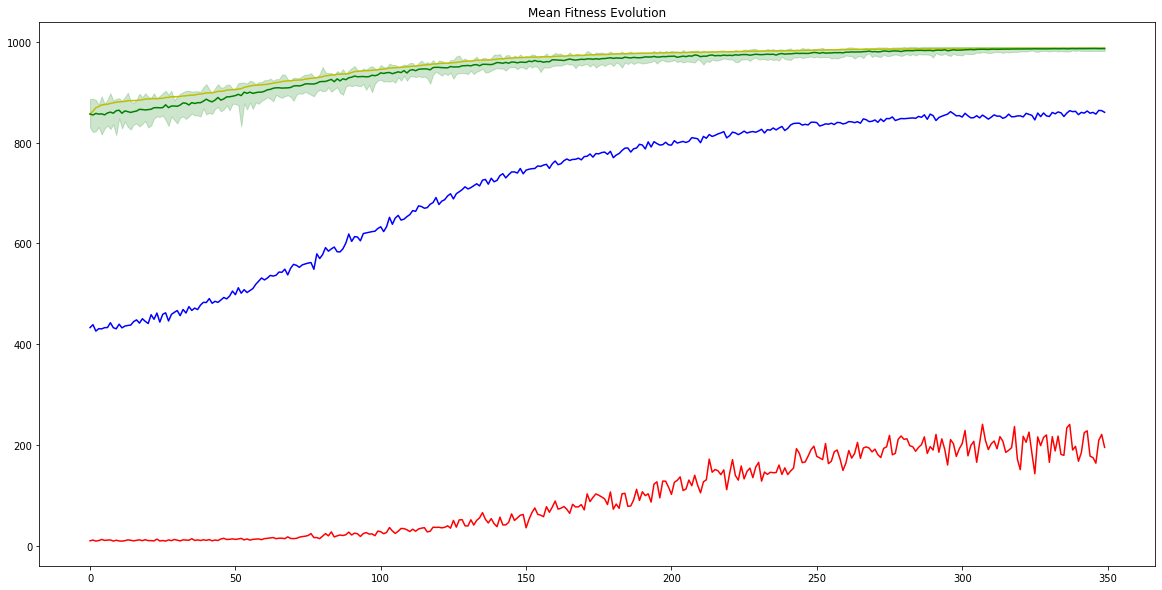

In [ ]:
rd.seed(42)
trainAndTest(30, 350, 0.01, 1, 0.02, 2, 4, 90, "entrada1.txt")

Média para melhores soluções: 989.5333333333333
Desvio padrão para melhores soluções: 0.5617433182117574

Melhor Solução encontrada para cada treino: 
1 45 9 27 67 35 11 62 61 8 39 92 71 12 94 28 38 23 42 98 3 46 31 89 50 21 65 82 44 68 26 58 37 15 18 56 79 63 19 70 81 60 25 7 87 91 90 34 84 52 88 20 85 14 51 76 4 41 80 32 53 2 64 5 66 74 43 96 72 77 75 13 83 49 17 54 24 36 95 10 59 22 57 78 93 29 55 69 30 99 73 33 86 40 6 48 97 16 47 100
989
1 53 91 90 75 21 23 57 78 93 97 9 55 13 37 15 67 35 85 77 24 52 88 70 54 22 94 10 69 30 99 73 62 16 79 65 4 41 66 95 20 48 34 19 58 42 98 18 6 49 56 87 84 36 3 46 64 25 7 11 40 17 82 59 80 32 31 50 96 72 61 8 81 60 44 51 74 43 68 12 45 92 14 29 89 39 71 27 2 47 33 5 28 38 26 83 76 63 86 100
990
1 53 91 67 59 22 31 12 20 98 90 26 83 49 69 32 73 78 28 42 10 77 95 92 14 29 74 43 65 82 63 46 40 17 54 35 85 19 48 25 96 3 94 13 37 15 7 47 58 50 72 4 27 75 21 86 57 30 6 23 79 38 89 39 71 8 84 36 68 80 16 2 34 5 66 33 45 24 52 88 81 64 55 41 44 97 9 18 56

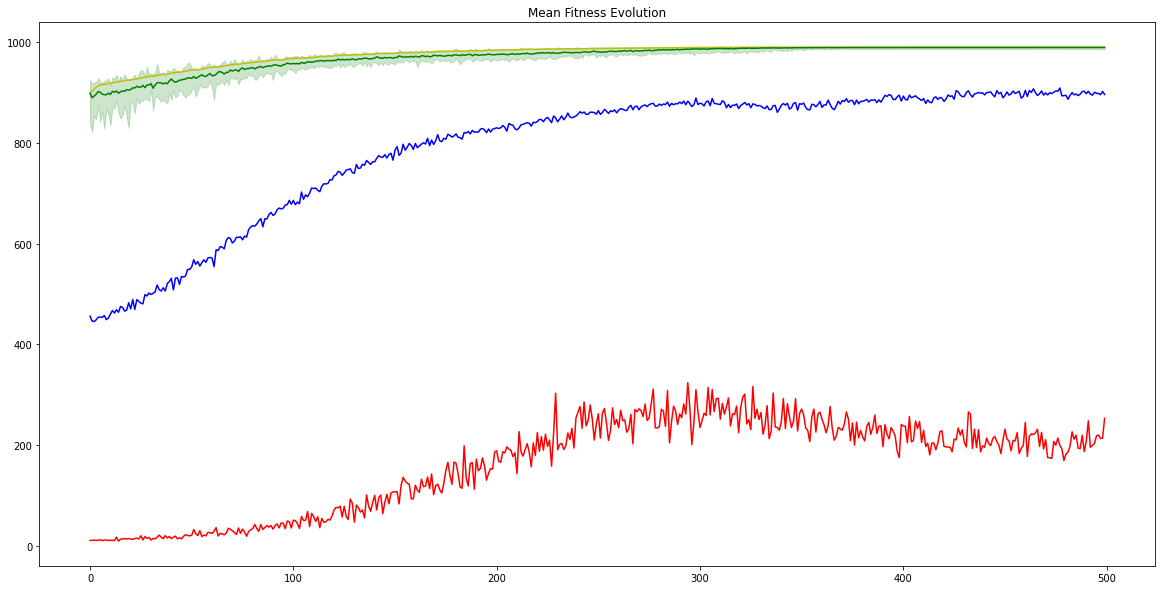

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 2, 7, 60, "entrada1.txt")

Média para melhores soluções: 167.43333333333334
Desvio padrão para melhores soluções: 0.495535624910617

Melhor Solução encontrada para cada treino: 
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 2 10 11 4 7 13 9

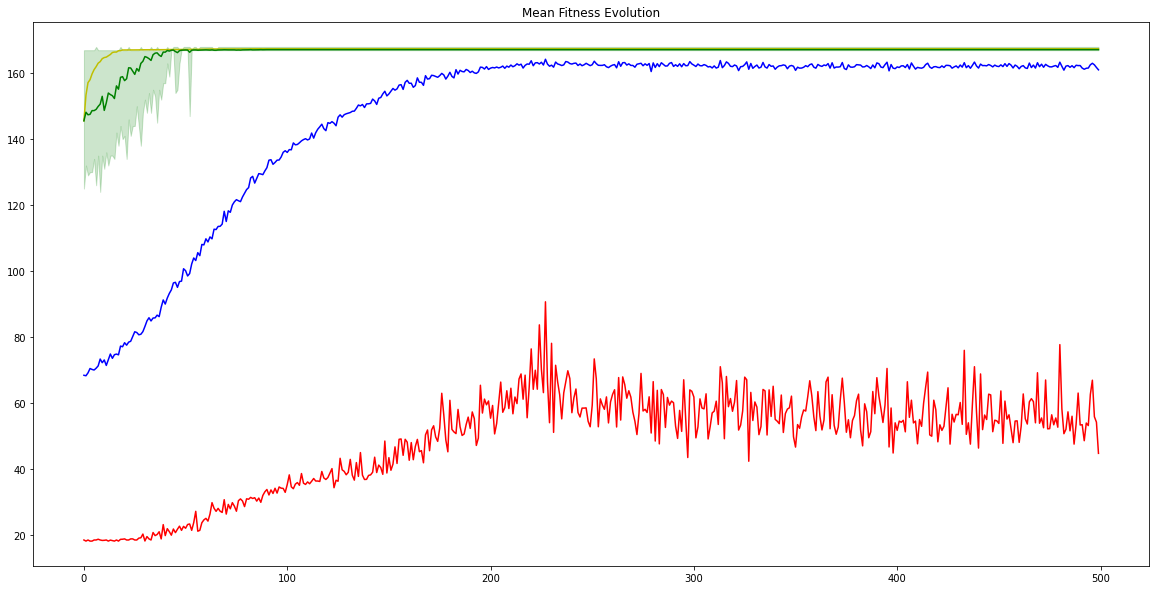

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 2, 7, 60, "entrada2.txt")

Média para melhores soluções: 167.26666666666668
Desvio padrão para melhores soluções: 0.44221663871405326

Melhor Solução encontrada para cada treino: 
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 14 9 8 12 17 2 5 3 4 7 13 10 11 18 16 6 20
167
1 19 15 2 10 11 4 7 13 9 8 12 17 18 16 6 5 3 14 20
168
1 19 15 14 9 8 12 17 2

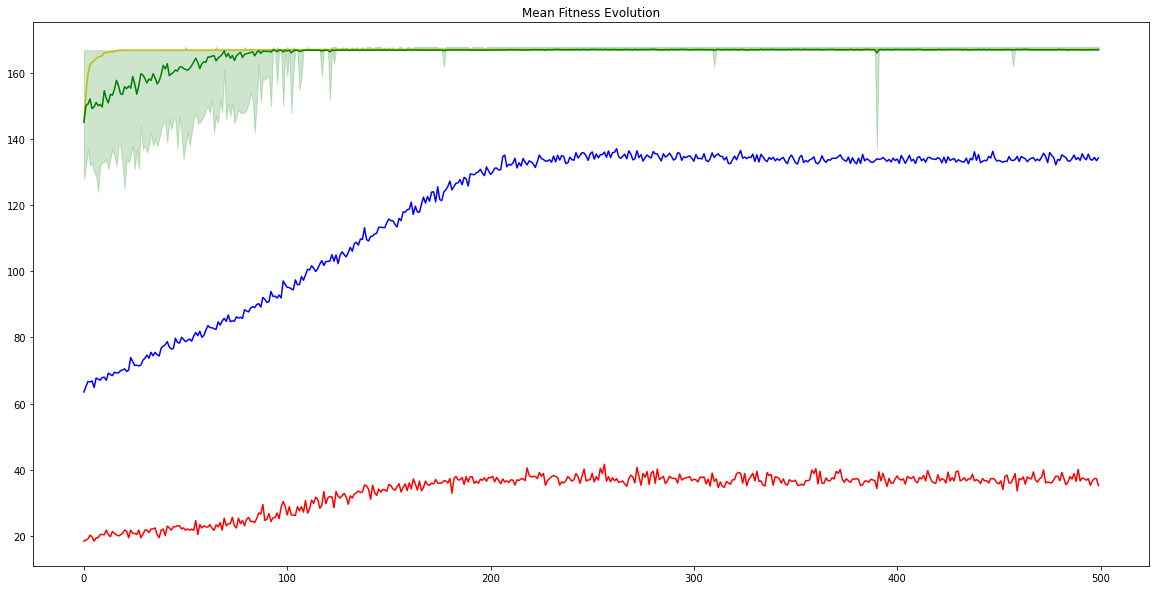

In [ ]:
rd.seed(42)
trainAndTest(30, 500, 0.01, 1, 0.02, 1, 7, 60, "entrada2.txt")

## 3.5 - Entrada 3

Média para melhores soluções: 9148.6
Desvio padrão para melhores soluções: 28.139651739138497

Melhor Solução encontrada para cada treino: 
1 316 503 391 839 934 358 906 405 662 323 549 57 577 344 954 307 838 690 225 399 876 904 445 327 237 956 879 850 306 285 412 257 109 87 530 459 45 678 548 284 387 373 269 289 452 250 922 385 715 854 330 422 869 798 811 668 803 701 574 586 203 818 444 847 38 396 25 262 454 579 376 97 605 362 309 512 66 892 561 467 817 609 910 156 785 831 308 253 545 515 455 74 664 215 230 165 546 567 212 595 315 599 42 741 112 219 415 448 997 240 90 168 4 742 935 915 47 461 581 654 698 560 913 511 378 786 815 660 898 417 190 5 228 868 76 520 94 333 777 669 390 637 352 631 550 970 132 348 157 615 130 694 395 556 603 174 406 100 82 901 547 610 102 371 957 725 597 175 524 598 216 988 521 756 912 39 843 478 761 620 27 480 825 971 92 622 236 286 774 666 602 679 760 649 198 751 98 167 506 458 447 783 875 379 650 596 829 220 110 176 801 865 578 919 903 428 544 982 437 2 63

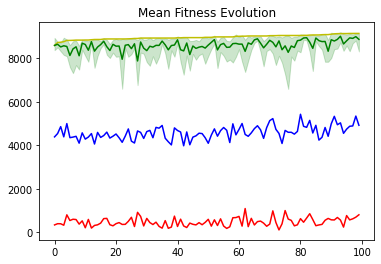

In [ ]:
rd.seed(42)
trainAndTest(5, 100, 0.01, 1, 0.02, 2, 5, 20, "entrada3.txt")

Média para melhores soluções: 9497.8
Desvio padrão para melhores soluções: 18.998947339260667

Melhor Solução encontrada para cada treino: 
1 42 724 786 552 3 633 689 914 176 427 734 748 215 280 968 985 193 877 964 604 528 757 47 623 44 208 983 30 896 498 632 655 977 295 779 573 250 349 614 631 744 759 144 114 341 409 894 702 186 854 448 480 205 760 972 146 493 976 473 36 629 326 892 512 602 394 579 463 207 700 646 945 520 444 692 580 777 943 991 340 830 709 185 873 284 718 824 796 344 84 876 155 526 7 117 323 181 285 234 462 166 530 140 15 936 83 765 303 179 190 218 865 478 562 46 688 859 939 531 254 439 272 138 486 680 24 789 374 173 947 566 244 457 686 649 125 20 482 187 139 675 68 451 251 133 366 811 149 668 431 417 663 626 667 827 328 879 850 230 383 524 352 617 525 41 333 192 402 533 808 243 541 900 370 219 997 954 63 956 216 475 242 76 395 503 258 800 26 816 496 167 136 72 189 373 53 37 122 818 34 298 93 210 560 371 315 203 537 866 314 145 337 738 986 621 638 821 871 223 867 636

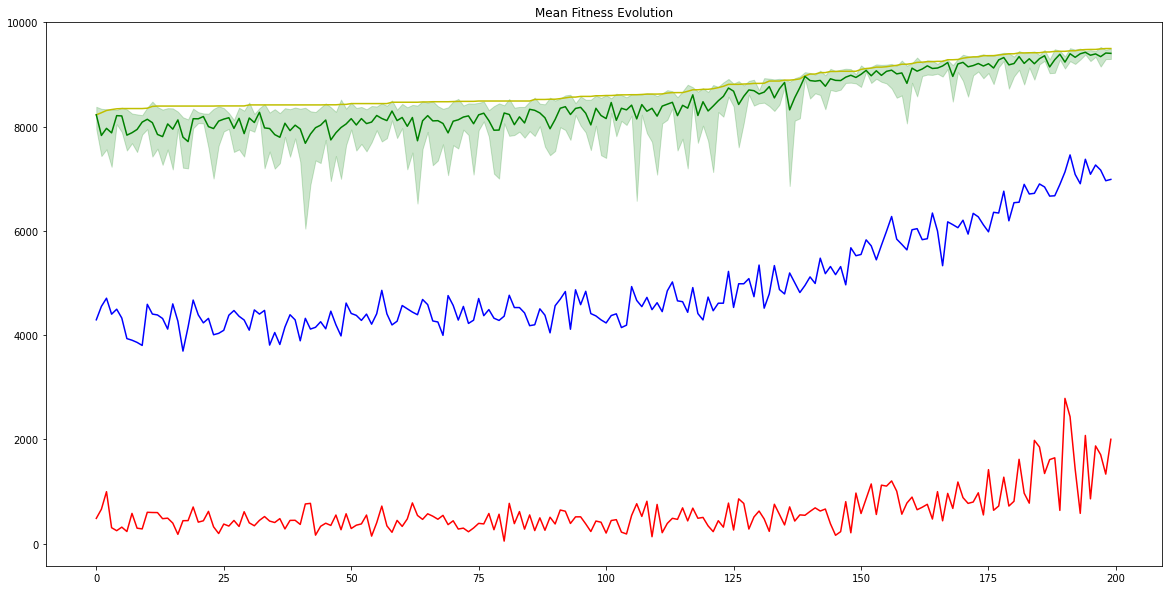

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.02, 2, 3, 20, "entrada3.txt")

Média para melhores soluções: 9580.2
Desvio padrão para melhores soluções: 33.71290554075694

Melhor Solução encontrada para cada treino: 
1 42 762 553 721 753 345 62 407 565 166 379 320 266 132 990 402 697 605 337 699 570 450 432 881 447 773 898 534 472 235 281 542 335 648 942 290 993 586 218 879 168 116 568 417 303 343 40 424 377 143 245 437 273 254 647 509 634 391 499 682 419 649 999 119 114 822 192 401 496 183 296 860 410 492 735 768 521 983 684 29 182 252 138 158 267 467 421 613 278 844 423 641 26 454 718 812 3 338 746 681 75 535 589 576 517 765 215 341 498 873 978 882 55 190 813 105 969 785 186 624 304 524 857 633 664 723 736 495 743 89 433 992 965 352 934 247 556 175 994 452 619 324 133 749 92 139 76 751 833 73 129 234 157 923 798 897 623 330 927 14 896 74 487 246 636 429 33 209 710 323 275 737 30 405 64 625 966 193 140 2 191 340 372 309 815 885 632 655 399 334 151 155 596 127 672 482 979 519 269 227 348 350 943 713 939 958 755 458 686 587 262 673 821 197 359 572 972 196 475 984

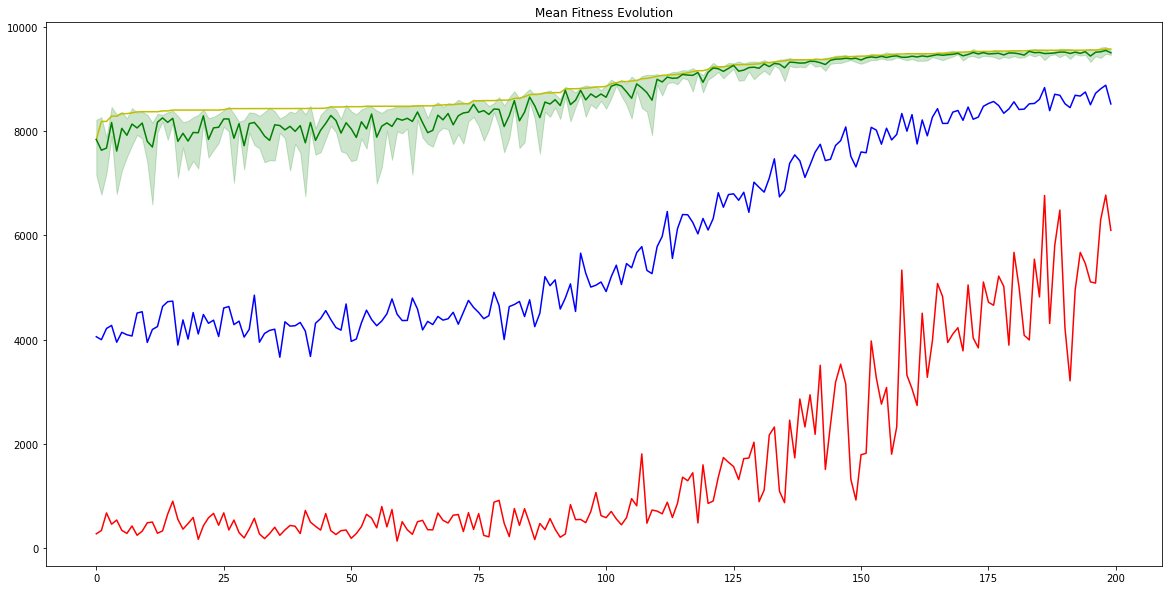

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.02, 3, 3, 20, "entrada3.txt")

Média para melhores soluções: 9479.0
Desvio padrão para melhores soluções: 26.817904466978774

Melhor Solução encontrada para cada treino: 
1 102 609 815 996 700 715 408 783 730 214 598 44 186 308 849 969 96 282 890 347 697 13 86 45 516 108 709 279 522 450 825 275 395 179 217 613 198 54 648 263 238 312 754 303 40 439 416 755 657 404 364 124 594 204 137 508 599 489 938 779 383 74 978 266 90 331 456 817 121 132 619 334 560 270 326 22 643 67 469 325 652 549 327 940 519 126 425 692 177 169 486 371 216 156 744 291 349 807 296 319 991 77 840 782 424 463 774 505 957 771 866 939 341 930 433 94 915 772 860 693 219 993 966 695 421 245 583 351 313 886 243 660 80 208 941 288 679 355 545 710 763 307 980 87 31 346 946 252 844 321 952 792 984 926 81 496 550 826 502 359 227 683 391 176 343 620 259 290 473 965 289 738 639 768 89 490 907 356 897 895 682 398 223 542 691 889 184 837 26 694 53 293 745 477 230 531 149 134 427 470 25 777 935 454 453 478 956 190 621 872 806 666 141 701 574 432 835 410 322 352

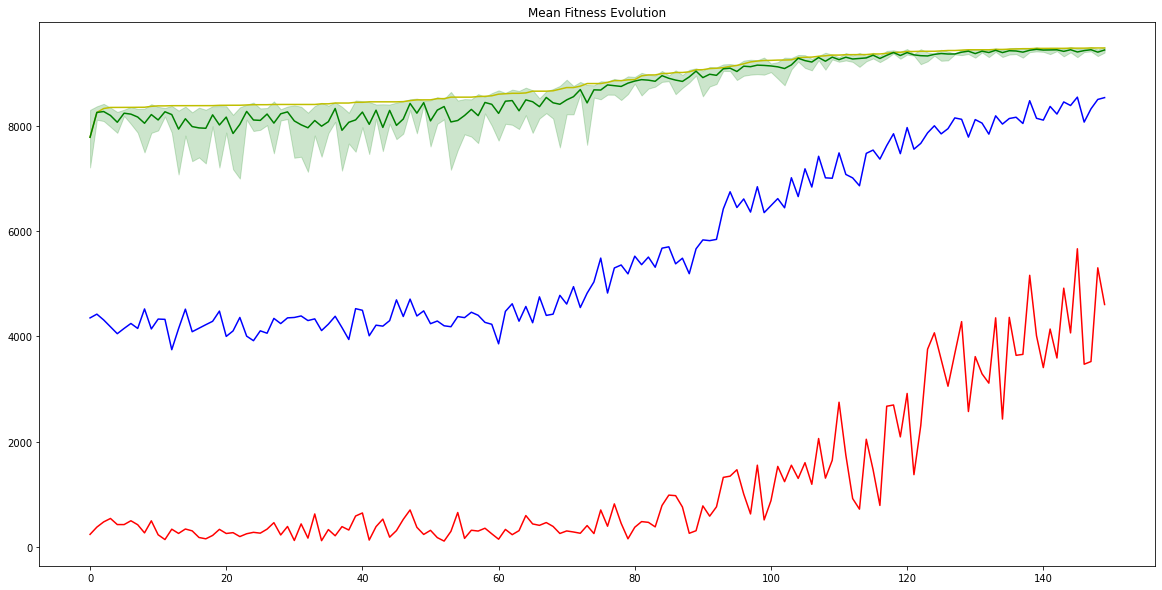

In [ ]:
rd.seed(42)
trainAndTest(5, 150, 0.01, 1, 0.02, 4, 3, 25, "entrada3.txt")

Média para melhores soluções: 9679.4
Desvio padrão para melhores soluções: 16.75231327309754

Melhor Solução encontrada para cada treino: 
1 662 309 863 480 779 421 156 631 903 849 269 390 610 535 334 987 801 986 647 33 993 408 426 107 731 116 76 501 429 285 572 582 785 694 830 329 122 367 783 896 202 858 672 516 765 776 375 557 814 954 720 362 259 714 838 245 168 869 980 728 32 373 764 385 324 254 439 41 444 719 313 393 195 563 696 614 591 451 874 823 139 345 53 349 996 106 238 973 105 167 281 627 834 573 272 664 211 474 370 360 431 177 827 878 246 493 843 746 742 63 146 180 530 793 494 347 484 225 506 543 319 30 844 487 676 787 603 235 831 583 960 95 452 12 44 59 131 739 907 911 967 16 381 725 798 485 158 132 150 695 416 837 604 775 331 9 278 766 183 640 782 261 809 327 201 546 659 519 491 260 80 743 507 737 808 236 905 877 943 224 733 660 668 821 538 303 623 611 566 531 455 315 111 904 523 891 712 184 892 753 255 341 717 806 369 47 589 768 104 673 108 567 612 856 125 865 351 492 683

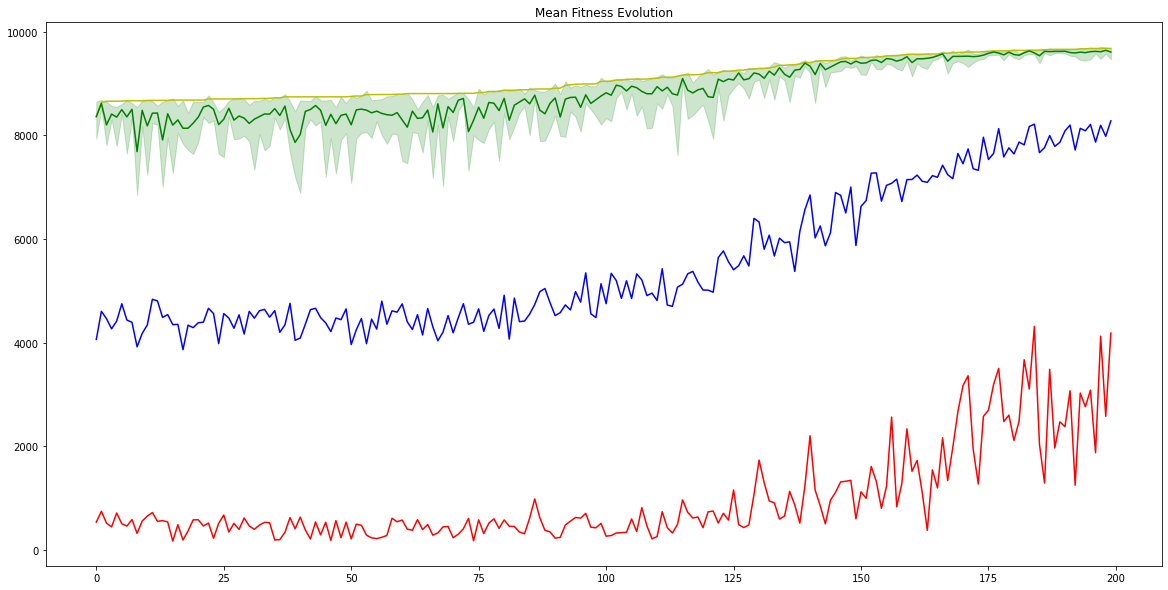

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.015, 3, 4, 20, "entrada3.txt")

Média para melhores soluções: 9619.0
Desvio padrão para melhores soluções: 6.387487769068525

Melhor Solução encontrada para cada treino: 
1 214 589 132 742 596 402 941 229 324 217 338 196 488 270 601 404 719 747 513 357 406 133 733 971 867 50 271 52 802 378 316 372 227 680 659 5 988 598 455 882 660 497 876 248 695 975 913 507 856 921 445 436 360 182 711 710 675 290 54 985 981 24 543 646 346 841 801 912 509 707 371 663 469 939 715 136 849 110 7 812 716 51 398 237 804 694 688 305 437 194 614 65 47 585 587 595 832 219 163 817 57 484 718 55 665 135 792 251 657 931 109 519 924 548 976 174 991 323 851 538 734 852 648 866 821 160 419 250 755 908 335 493 771 273 239 721 391 516 108 951 494 381 26 117 885 706 756 286 211 689 823 793 93 409 238 568 708 699 560 119 255 977 545 796 984 570 396 645 677 544 365 236 868 606 205 594 583 919 769 138 423 890 73 829 307 31 76 824 79 925 269 388 860 339 871 537 915 382 593 2 672 184 640 430 520 126 827 41 654 967 433 429 32 858 910 725 69 13 752 495 278 

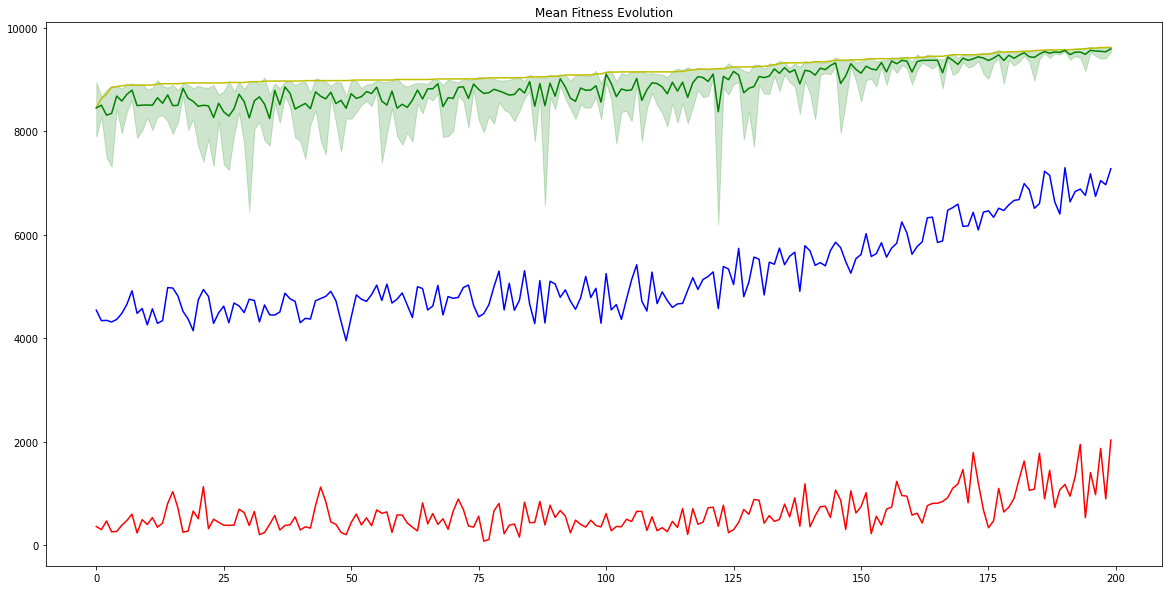

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.01, 3, 5, 20, "entrada3.txt")

Média para melhores soluções: 9718.4
Desvio padrão para melhores soluções: 15.447977213862014

Melhor Solução encontrada para cada treino: 
1 322 445 629 306 889 988 680 997 838 846 367 189 688 184 948 983 176 591 239 200 774 765 217 235 174 521 52 213 732 417 334 111 177 693 807 723 488 149 81 69 969 5 147 245 650 368 82 714 770 656 567 42 544 503 995 370 115 403 164 510 764 690 574 351 66 478 761 276 299 75 251 267 626 780 21 113 990 248 354 959 46 63 615 911 868 104 847 288 181 394 477 927 515 835 570 882 84 696 713 902 373 242 274 470 836 827 202 335 284 934 441 745 716 77 221 87 877 611 634 968 71 207 809 72 689 12 930 347 407 845 159 804 628 379 931 743 357 178 967 290 782 605 366 704 616 637 771 613 508 837 812 789 171 506 22 727 85 481 402 697 906 165 531 728 853 230 857 401 219 801 380 395 775 922 385 907 2 13 138 315 203 507 411 73 129 297 192 422 822 984 383 100 746 127 364 400 327 466 919 208 748 662 828 430 523 575 120 324 350 565 687 842 932 627 724 573 887 805 532 289 50

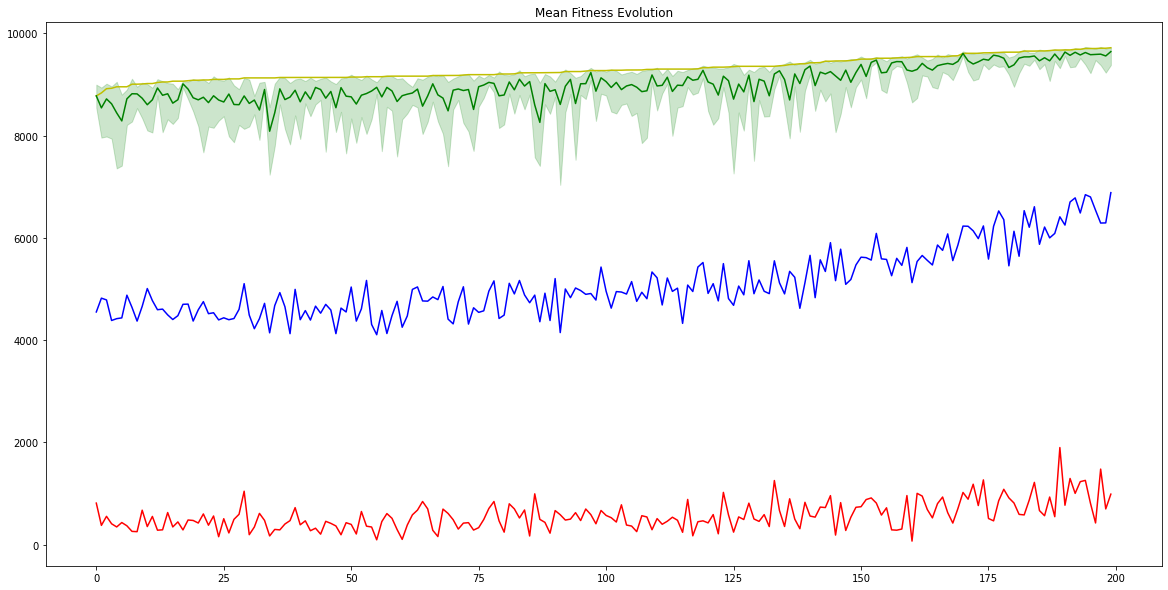

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.015, 2, 6, 20, "entrada3.txt")

Média para melhores soluções: 9600.4
Desvio padrão para melhores soluções: 13.350655414622908

Melhor Solução encontrada para cada treino: 
1 781 451 983 549 774 283 292 724 196 15 155 147 513 464 176 427 780 723 341 889 620 803 191 476 599 383 459 904 235 550 770 252 999 640 69 54 367 519 126 719 941 330 637 946 908 63 491 702 894 807 858 857 240 955 210 792 407 982 419 740 635 869 783 639 19 403 156 259 818 860 267 546 384 465 109 274 808 840 695 230 59 659 816 405 457 728 386 66 906 17 43 766 365 186 468 578 455 316 755 899 672 824 693 957 221 141 275 500 564 168 648 942 542 929 495 29 375 164 56 916 8 943 658 888 394 347 294 378 919 413 297 192 101 779 973 190 532 289 65 393 952 37 166 350 206 95 436 555 10 291 125 986 938 355 711 548 572 676 153 398 89 115 705 605 323 851 364 761 276 408 905 14 561 281 329 121 517 700 226 753 321 902 169 371 910 577 699 880 939 892 106 841 158 265 606 368 260 117 998 960 670 974 530 421 961 662 872 833 591 756 335 736 227 497 874 93 167 85 511 877

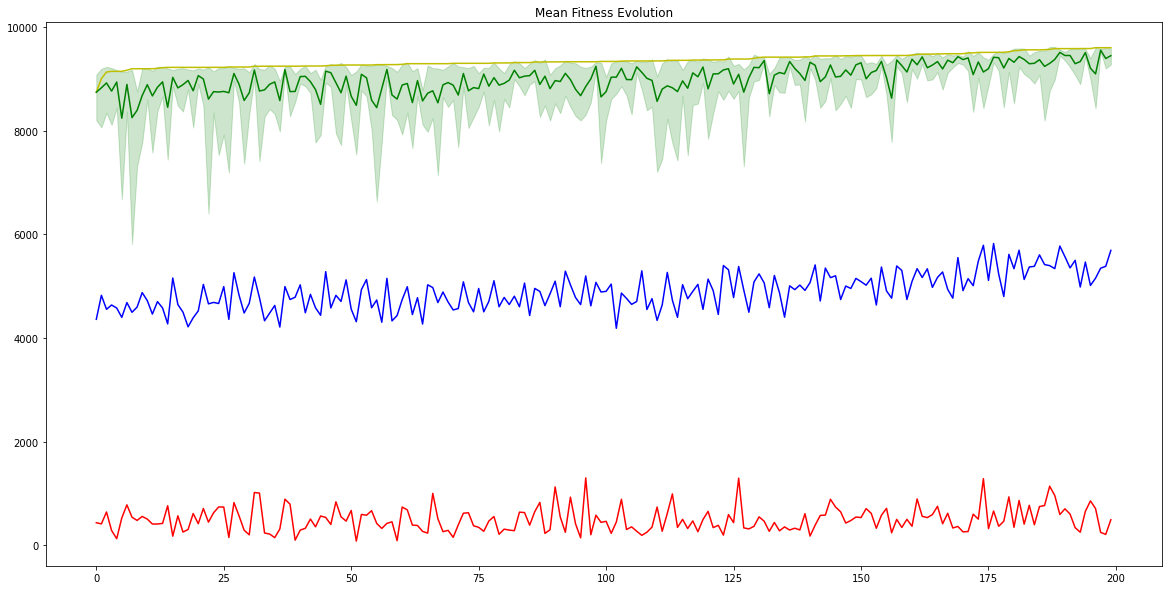

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.01, 2, 7, 20, "entrada3.txt")

Média para melhores soluções: 9839.2
Desvio padrão para melhores soluções: 10.303397497913007

Melhor Solução encontrada para cada treino: 
1 489 682 251 280 487 246 212 568 171 275 103 395 868 861 824 625 737 842 287 88 240 116 397 66 986 689 105 598 792 600 415 996 298 657 274 889 876 924 170 540 255 874 85 314 866 459 432 573 586 372 507 950 101 193 911 658 14 711 701 597 558 654 938 802 161 100 531 603 543 751 284 773 273 633 556 852 58 225 481 191 188 199 320 472 343 458 495 595 376 513 223 801 380 749 634 292 955 848 833 162 641 312 776 411 208 464 185 779 544 605 362 219 960 832 567 42 97 108 860 384 309 811 149 998 299 891 819 988 365 630 71 506 10 655 110 421 355 77 175 130 52 577 164 548 424 579 709 704 20 117 168 187 307 537 386 500 369 104 546 414 820 366 418 992 509 971 64 666 713 361 592 192 738 290 665 43 670 469 613 905 315 423 83 166 145 525 375 892 898 961 916 454 958 609 636 512 933 21 475 896 763 95 452 932 601 843 716 79 538 460 814 490 533 664 211 201 786 157 81 3

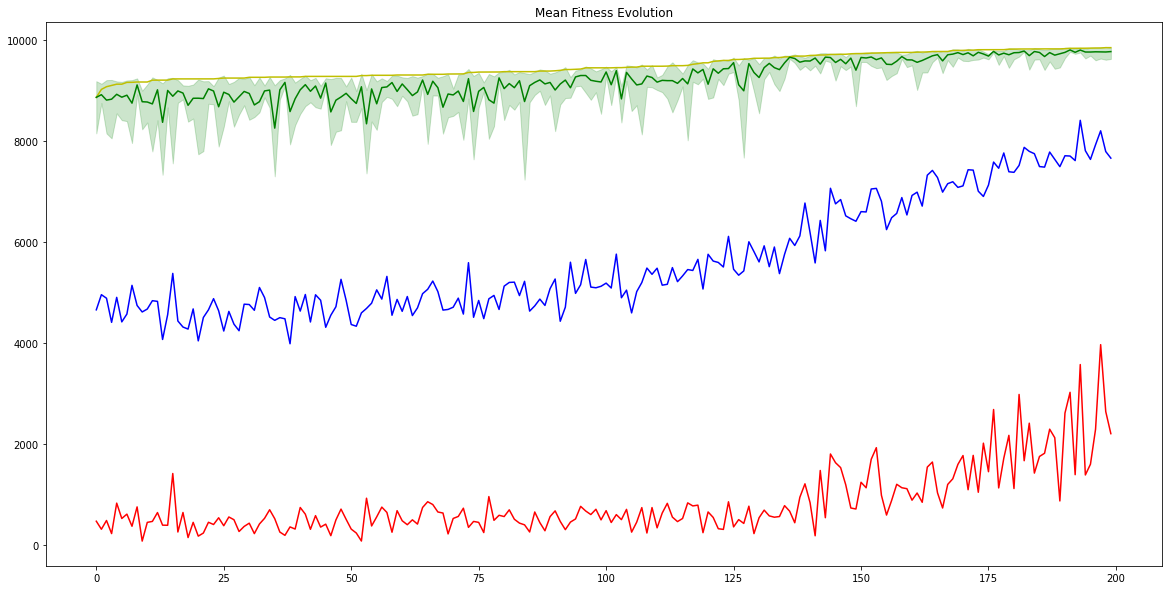

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.02, 2, 7, 20, "entrada3.txt")

Média para melhores soluções: 9789.6
Desvio padrão para melhores soluções: 14.77294825009551

Melhor Solução encontrada para cada treino: 
1 156 266 65 351 850 602 174 172 286 958 287 254 819 670 902 371 892 938 671 473 333 20 568 907 481 646 332 203 558 540 392 551 349 988 521 382 612 297 163 301 418 751 833 325 657 660 795 673 122 918 434 770 322 214 503 227 27 46 445 629 180 634 968 469 123 840 522 680 32 959 772 786 755 624 628 606 78 727 167 874 391 647 661 401 879 66 495 610 476 617 761 675 499 997 789 67 70 114 77 939 927 270 616 331 909 798 316 855 489 257 662 976 176 820 684 157 638 175 200 146 588 12 314 338 672 64 210 44 186 139 650 106 779 713 71 926 181 234 538 846 399 716 129 753 317 830 412 905 423 80 339 154 283 383 99 601 354 273 561 762 688 505 953 989 581 987 109 177 844 193 921 851 964 894 420 168 903 515 416 415 996 765 479 49 482 704 950 556 648 164 310 511 95 357 477 288 595 282 321 985 25 783 63 573 3 447 718 812 873 659 295 211 291 698 814 299 107 137 876 885 8

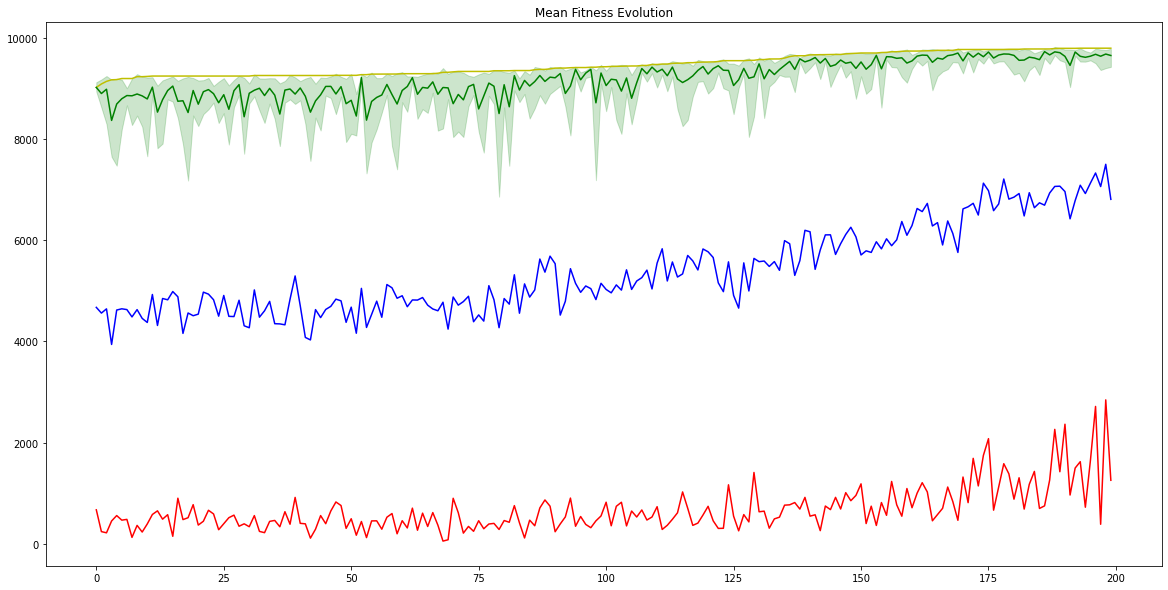

In [ ]:
rd.seed(42)
trainAndTest(5, 200, 0.01, 1, 0.025, 1.5, 7, 20, "entrada3.txt")